In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import os

In [2]:
from sklearn.decomposition import FastICA
import scipy
import scipy.signal as scsig

In [3]:
from laser_dataset import FileReader
from synchronization import Synchronizer


## Functions

In [4]:
def standardize(_sig):
    # zero-mean
    sig = _sig - _sig.mean()
    # normlize
    sig = sig / np.abs(sig).max()
    return sig

## (0) Load the meta data (Versuchstabelle) -> for file names

In [5]:
path_meta = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/00_Versuchsplan_iHub.xlsx'
metadf = pd.read_excel(
    path_meta,
    sheet_name=1,
    usecols="B:F",
    nrows=71
)

In [6]:
# Path to the data
path_dew = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/01_DEWETRON_csv'
path_izfp = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/02_QASS'

# Example trial
dataID = 64 # np.random.randint(len(metadf)) + 1
row = dataID - 1
fname_dew = metadf['DEWETRON'][row]
qassNo = str(metadf['QASS'][row]).zfill(3)
print(qassNo)

127


## (1.a) Load the DEW synch signal

In [7]:
synch = Synchronizer()
t_dew, S_dew = synch.load_dew(path_dew, fname_dew, sigtypes=['Sync_V', 'Sync/Derivative_V/s'])
s_dew = S_dew[:, 0]
sprime_dew = S_dew[:, 1]

In [8]:
# Zero-mean and normalize
s_dew = s_dew - s_dew.mean()
s_dew = s_dew / np.abs(s_dew).max()

#sprime_dew = sprime_dew - sprime_dew.mean()
#sprime_dew = sprime_dew / np.abs(sprime_dew).max()

## (1.b) Load the QASS synch signal

In [9]:
synch = Synchronizer()
# Load the derivative of the synch signal (Ch.4)
t_qass, s_qass = synch.load_qass(path_izfp, qassNo, standardize=False)


## (2.a) Numerical integration of the DEW synch signal

In [10]:
# Dnoise
# Reformulate into an array: 3 collumns of 1s (=T_synch) vectors
S = np.array([sprime_dew[:synch.N], sprime_dew[synch.N:2*synch.N], sprime_dew[2*synch.N:3*synch.N]]).T
# ICA
transformer = FastICA(n_components=2, random_state=0, whiten='unit-variance')
S_ica = transformer.fit_transform(S)

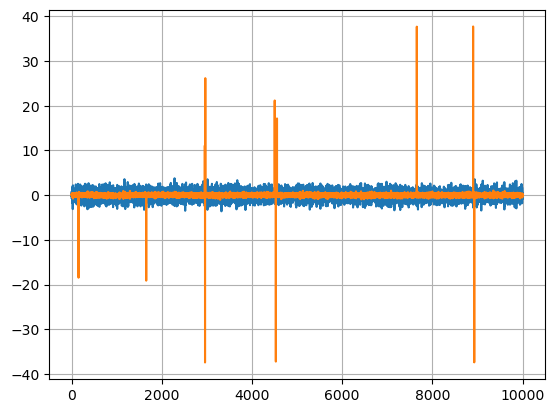

In [11]:
%matplotlib inline
plt.figure()
plt.plot(S_ica[:, 1])
plt.plot(S_ica[:, 0])
plt.grid(True)

In [12]:
# Denoise -> otherwise the integrated signal is continuously increasing (i.e. accumulating the noise)
sprime_ica = S_ica[:, 0]

# Integrate the dewetron signal
#y = scipy.integrate.cumulative_trapezoid(np.concatenate((np.zeros(1), sprime_ica)))
y = scipy.integrate.cumulative_trapezoid(np.concatenate((np.zeros(1), sprime_dew)))

# Zero-mean and normalize
y = standardize(y)

## (2.b) Numerical integration of the QASS synch signal

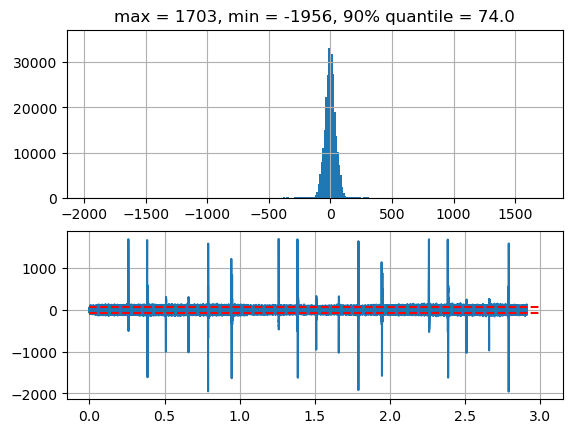

In [13]:
q = 0.9
quantile = np.quantile(np.abs(s_qass), q)

fig, (ax0, ax1) = plt.subplots(2, 1)

ax0.hist(s_qass, bins=300)
ax0.set_title(f'max = {s_qass.max()}, min = {s_qass.min()}, {round(q*100)}% quantile = {quantile}')
ax0.grid(True)

ax1.plot(t_qass, s_qass)
ax1.hlines(y=[-quantile, quantile], xmin = 0, xmax=3, linestyles='--', color='r')
ax1.grid(True)

plt.show()

In [14]:
# Denoise based on the statistics: 98% quantile = noise
idx_nonnoise = np.argwhere(np.abs(s_qass) > quantile)
sqass_denoised = np.zeros(len(s_qass))
sqass_denoised[idx_nonnoise] = s_qass[idx_nonnoise]

# plt.figure()
# plt.plot(t_qass, sqass_denoised)

In [15]:
# Integrate
# Integrate the downsampled QASS signal
y_qass1 = scipy.integrate.cumulative_trapezoid(np.concatenate((np.zeros(1), s_qass[::10]))) 
y_qass1 = standardize(y_qass1)
# Integrate the "denoised" QASS signal
y_qass2 = scipy.integrate.cumulative_trapezoid(np.concatenate((np.zeros(1), sqass_denoised)))
y_qass2 = standardize(y_qass2)

## (3) Compare the integral results

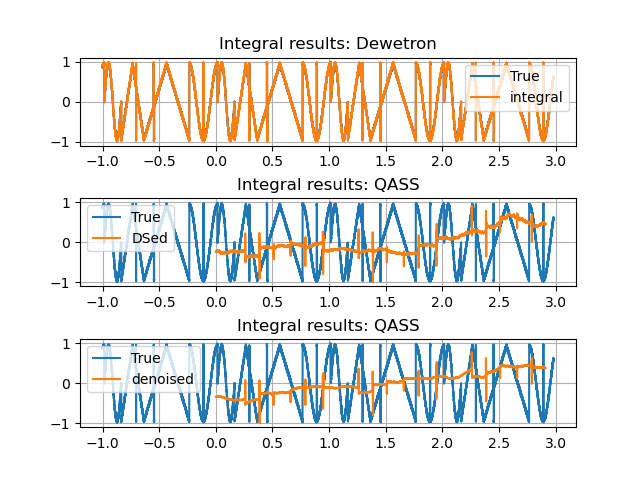

In [16]:
# Compare the integral vs true values
%matplotlib widget
#%matplotlib inline

fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
plt.subplots_adjust(hspace=0.6) # more spacing between rows


ax0.set_title('Integral results: Dewetron')
ax0.plot(t_dew, s_dew, label='True')
ax0.plot(t_dew[:len(y)], y, label='integral')
ax0.legend(loc='upper right')
ax0.grid(True)


ax1.set_title('Integral results: QASS')
ax1.plot(t_dew, s_dew, label='True')
ax1.plot(t_qass[::10], y_qass1, label='DSed')
ax1.legend(loc='upper left')
ax1.grid(True)


ax2.set_title('Integral results: QASS')
ax2.plot(t_dew, s_dew, label='True')
ax2.plot(t_qass, y_qass2, label='denoised')
ax2.legend(loc='upper left')
ax2.grid(True)